In [1]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches
import mplstereonet
import skimage.exposure
import harmonica as hm
import verde as vd

import micromag as mg

import time

# Read the real data

In [2]:
data_dir = pathlib.Path("..") / "data"
data = mg.load_qdm(data_dir / "Bz_uc0.mat")

# median = np.median(data.bz.values)
# data.bz.values -= median


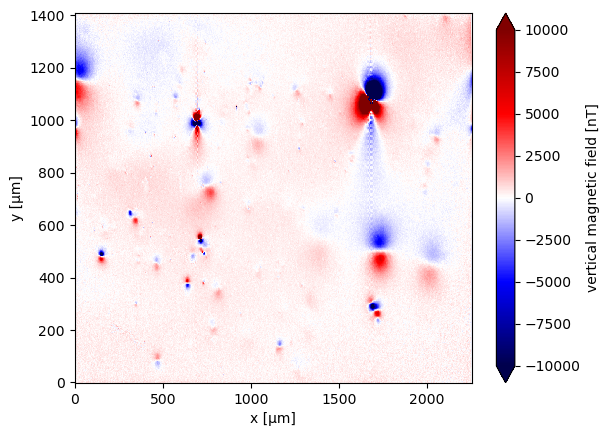

In [3]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=10000, vmin=-10000)

# Regional separation

In [4]:
data_table = vd.grid_to_table(data)

regional = vd.Trend(degree=3).fit((data_table.x, data_table.y), data.bz.values.ravel())

shape = data.bz.shape
regional_predicted=regional.predict((data_table.x, data_table.y))
regional_predicted = np.reshape(regional_predicted, shape)


data = data.assign(regional_predicted=(("y", "x"), regional_predicted))
data.regional_predicted.attrs = {"long_name": "vertical magnetic field", "units": "nT"}

# data.bz.values -= data.regional_predicted.values

data

<xarray.Dataset> Size: 14MB
Dimensions:             (y: 600, x: 960)
Coordinates:
  * x                   (x) float64 8kB 0.0 2.35 4.7 ... 2.251e+03 2.254e+03
  * y                   (y) float64 5kB 0.0 2.35 4.7 ... 1.405e+03 1.408e+03
    z                   (y, x) float64 5MB 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0
Data variables:
    bz                  (y, x) float64 5MB 352.4 94.89 41.62 ... -53.56 2.103
    regional_predicted  (y, x) float64 5MB -158.8 -156.5 -154.1 ... 508.7 510.8
Attributes:
    file_name:  ../data/Bz_uc0.mat

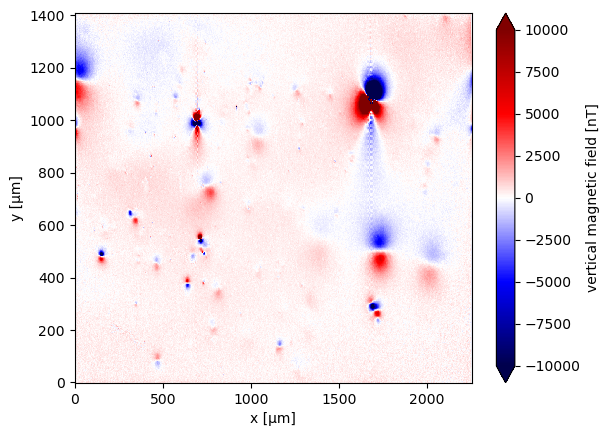

In [5]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=10000, vmin=-10000)

# Anomaly detection

First part of our method is an automatic way to detect and separate the signal of each dipole in the data. This is done in the following steps:

1. Upward continue the data to suppress high frequency noise
2. Calculate the total gradient amplitude (TGA) to concentrate the anomalies on top of the sources
3. Contrast stretch the TGA to highlight weaker sources
4. Run the Laplacian of Gaussian (LoG) method for blog detection to find the anomalies

In [6]:
# table = vd.grid_to_table(data)

## 1. Upward continue the data to suppress the high-frequency noise

In this step, we want to upward continue as little as possible to make sure we retain most of the signal.

In [7]:
height_difference = 5

# Have to assign the same points as the data because the Harmonica
# transforms give slightly different coordinates due to round-off.
# This is a bug and is being worked on.
data_up = (
    hm.upward_continuation(data.bz, height_difference)
    .assign_attrs(data.bz.attrs)
    .to_dataset(name="bz")
    .assign_coords(x=data.x, y=data.y)
    .assign_coords(z=data.z + height_difference)
)

data_up.z.attrs = {"units": "µm"}

data_up

/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset> Size: 9MB
Dimensions:  (y: 600, x: 960)
Coordinates:
  * x        (x) float64 8kB 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
  * y        (y) float64 5kB 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
    z        (y, x) float64 5MB 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 5MB 206.0 199.8 194.2 199.0 ... 266.5 236.6 204.7

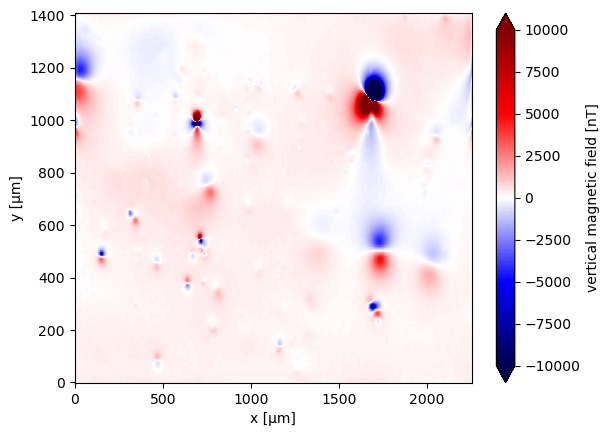

In [8]:
scale = 10000
data_up.bz.plot.pcolormesh(cmap="seismic", vmax=scale, vmin=-scale)

## 2. Calculate the TGA

We do this with finite difference derivatives to avoid amplifying noise.

In [9]:
data_up = data_up.assign(mg.data_gradients(data_up.bz))
data_up

/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset> Size: 28MB
Dimensions:  (y: 600, x: 960)
Coordinates:
  * x        (x) float64 8kB 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
  * y        (y) float64 5kB 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
    z        (y, x) float64 5MB 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 5MB 206.0 199.8 194.2 199.0 ... 266.5 236.6 204.7
    tga      (y, x) float64 5MB 6.937 8.888 8.154 6.013 ... 24.13 23.33 21.11
    x_deriv  (y, x) float64 5MB -2.652 -2.519 -0.1715 ... -9.835 -13.17 -13.58
    y_deriv  (y, x) float64 5MB 6.135 8.487 7.263 4.485 ... -17.43 -11.83 -1.096
    z_deriv  (y, x) float64 5MB 1.858 0.7877 3.704 -2.628 ... 13.48 15.2 16.12

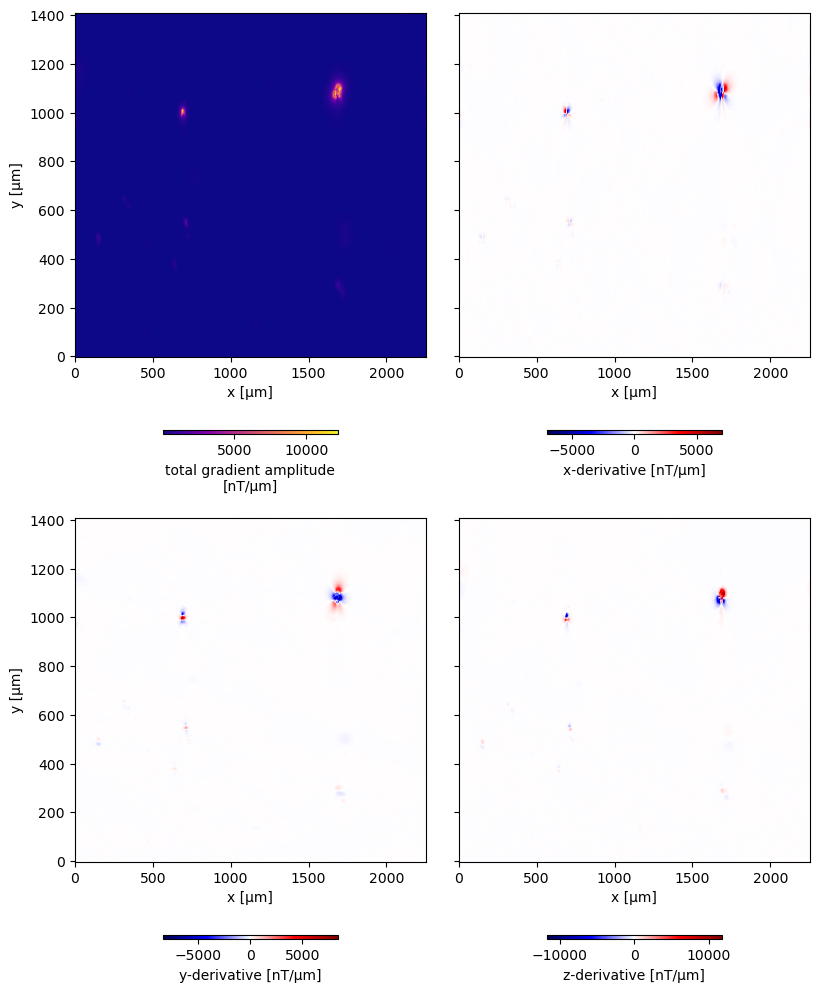

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10), sharey="row")
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.15, shrink=0.5)
for field, ax in zip(["tga", "x_deriv", "y_deriv", "z_deriv"], axes.ravel()):
    if field == "tga":
        cmap = "plasma"
        vmax=None
        vmin=None
    else:
        vmax= None# 500
        vmin= None#-500
        cmap="seismic"
    data_up[field].plot.pcolormesh(ax=ax, cmap=cmap, cbar_kwargs=cbar_kwargs, vmax=vmax, vmin=vmin)
for ax in axes.ravel():
    ax.set_aspect("auto")
    
axes[0,1].set_ylabel(None)
axes[1,1].set_ylabel(None)
plt.tight_layout(pad=0, h_pad=0, w_pad=2)

## 3. Stretch the contrast

Now we need to stretch the contrast of the TGA to make the anomalies easier to detect.

In [11]:
stretched = skimage.exposure.rescale_intensity(
    data_up.tga, 
    in_range=tuple(np.percentile(data_up.tga, (1, 99))),
)

data_up = data_up.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

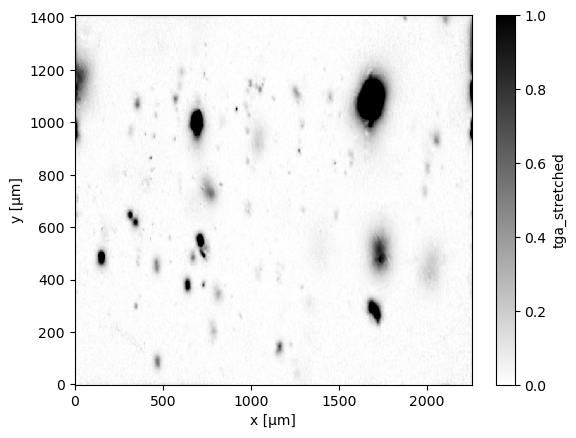

In [12]:
data_up.tga_stretched.plot.pcolormesh(cmap="gray_r")

## 4. Blob detection

To detect the bounding boxes of each anomaly, we use the LoG method in scikit-image. The code below calls it with some conveniences, like passing the range of anomaly sizes in physical units (µm) instead of number of pixels. It returns the bounding box of each anomaly (x_min, x_max, y_min, y_max) also in physical units.

In [13]:
start_detection_time = time.perf_counter()

windows = mg.detect_anomalies(
    data_up.tga_stretched, 
    size_range=[20, 200],
    size_increment=1.3,
    threshold=0.025,
    overlap=0.0,
    exclude_border=30,
    nsizes=10,
)

end_detection_time = time.perf_counter()

In [14]:
detection_time = end_detection_time-start_detection_time

print(f'{np.shape(windows)[0]} potential sources detected within {round(detection_time, 4)} seconds', )

100 potential sources detected within 1.6082 seconds


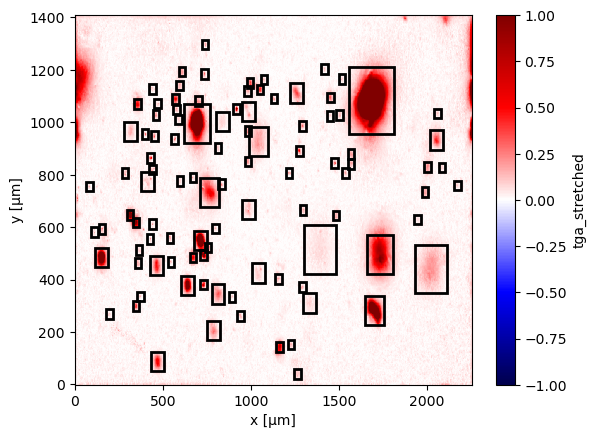

In [15]:
ax = plt.subplot(111)
scale = 1
data_up.tga_stretched.plot.pcolormesh(ax=ax, cmap="seismic", vmax=scale, vmin=-scale)
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)  
ax.set_aspect("auto")

Now that we know the bounding box of each anomaly, we can run the Euler deconvolution and moment inversion for each anomaly separately.

# Euler Deconvolution and Inversion (Standard method)

Run the Euler Deconvolution and the inversion on each window.

In [16]:
start_inversion_time = time.perf_counter()

positions = []
estimated_dipole_moments = []
estimated_stds = []
calculated_r2 = []
calculated_SNR = []
windows_filtered = []
base_levels = []
for window in windows:
    anomaly = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
    # anomaly = data.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    # base_level = 0
    
    data_minus_background = anomaly.bz.values - base_level
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}
    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(
        anomaly.data_minus_background, position,
    )

    # Filter out solutions that don't meet quality criteria
    bad_euler = False#position[2] > 0
    poor_fit = False
#     poor_fit = r2 < 0.5
    bad_euler = position[2] > 0
    if bad_euler or poor_fit:
        continue
    print("R²: %s and SNR: %s"%(r2,SNR))  
    positions.append(position)  
    estimated_dipole_moments.append(moment)
    estimated_stds.append(mg.covariance_to_angle_std(moment, covariance))
    calculated_r2.append(r2)
    calculated_SNR.append(SNR)
    windows_filtered.append(window)
    base_levels.append(base_level)
positions = np.transpose(positions)


end_inversion_time = time.perf_counter()

R²: 0.8878576913878354 and SNR: 9.518730490743211
R²: 0.917351363699056 and SNR: 10.937779141369932
R²: 0.9946005039683814 and SNR: 23.059612094205395
R²: 0.7460754916587349 and SNR: 5.9772549247430735
R²: 0.9728510000308487 and SNR: 15.665320041566586
R²: 0.9972637031581711 and SNR: 25.690723677427002
R²: 0.9816835127392123 and SNR: 17.519415551075
R²: 0.9848937372877455 and SNR: 18.228055439427685
R²: 0.9991782555940185 and SNR: 31.41196258138453
R²: 0.7373843539031366 and SNR: 6.19558242818107
R²: 0.996075673389637 and SNR: 24.07048352494059
R²: 0.9603006258010941 and SNR: 14.128411903182084
R²: 0.9991423021526933 and SNR: 30.676100198449248
R²: 0.9970542831194269 and SNR: 25.86971781470576
R²: 0.9515262756130506 and SNR: 13.278426395217409
R²: 0.938429171309107 and SNR: 12.116199987881567
R²: 0.9949075769752441 and SNR: 23.08151531016862
R²: 0.9790322181547488 and SNR: 16.790183675715898
R²: 0.9679487807235353 and SNR: 15.023904818254179
R²: 0.966754444912002 and SNR: 14.9183209207

In [17]:
inversion_time = end_inversion_time-start_inversion_time
print(f"{positions.shape[1]} euler positions and dipole moments estimated within {round(inversion_time, 4)} seconds", )

75 euler positions and dipole moments estimated within 1.5977 seconds


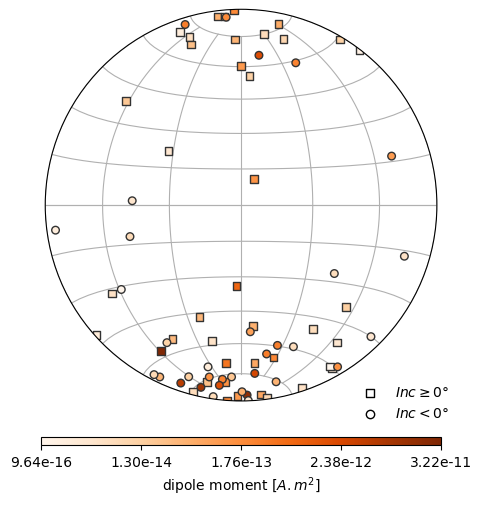

In [18]:
fig, ax = mplstereonet.subplots(1, 1, figsize=(4, 4), constrained_layout=True)
ax.grid()
estimated = mg.vector_to_angles(estimated_dipole_moments)
scatter_args = dict(
    vmin=np.log10(np.min(estimated[2])),
    vmax=np.log10(np.max(estimated[2])),
    cmap="Oranges",
    edgecolors="#333333",
    linewidths=1,
    s=30,
    zorder=2,
)
pos_inc = estimated[0] > 0
tmp = ax.scatter(
    *mplstereonet.line(estimated[0][pos_inc], estimated[1][pos_inc]),
    c=np.log10(estimated[2][pos_inc]),
    marker="s",
    **scatter_args,
)
tmp = ax.scatter(
    *mplstereonet.line(-estimated[0][~pos_inc], estimated[1][~pos_inc]),
    c=np.log10(estimated[2][~pos_inc]),
    marker="o",
    **scatter_args,
)

ticks=np.linspace( np.log10(np.min(estimated[2])),
                   np.log10(np.max(estimated[2])), 5)
tick_labels = []
for i in (ticks):
    tick_labels.append("{:.2e}".format(10**i))

    
clb = fig.colorbar(
    tmp, 
    cax=fig.add_axes([0, -0.1, 1, 0.02]), 
    orientation="horizontal", 
    label="dipole moment [$A.m^2$]",
    format="%.2e",
    ticks = ticks).set_ticklabels(tick_labels)

plt.scatter([],[], marker='s', color='white', edgecolors='k', label=r'$Inc \geq 0° $')
plt.scatter([],[], marker='o', color='white', edgecolors='k', label=r'$Inc < 0° $')

legend = plt.legend(bbox_to_anchor=(1.05, 9.0), frameon=1, framealpha=1.0)
frame = legend.get_frame()
frame.set_facecolor('w')
frame.set_edgecolor('w')

plt.show()

# Interative Euler deconvolution

In [19]:
import scipy as sp

# @numba.jit(nopython=True, parallel=True)
def goal_function(parameter, obs_data, coordinates, amplitude, x_0, y_0, z_0):
    bz = mg.dipole_bz(coordinates, 
                      ([parameter[0]*x_0], [parameter[1]*y_0], [parameter[2]*z_0]),
                     np.array([parameter[3], parameter[4], parameter[5]])*amplitude
                     )
                   
    
    Res = np.linalg.norm(obs_data-bz.ravel())
    # print(Res)
    return(Res)

In [20]:
x_, y_ = np.meshgrid(data.x.values, data.y.values)
coordinates = ([x_, y_ , data.z.values])
# predicted_data = mg.dipole_bz(predicted_coordinates, positions, estimated_dipole_moments)

In [21]:
import warnings
import rich.progress

warnings.filterwarnings("ignore")

start_itr_euler_time = time.perf_counter()

x_concat = []
y_concat = []
z_concat = []
bz_concat = []
xc_concat = []
yc_concat = []
zc_concat = []
z_deriv_concat = []

estimated_dipole_moments_itr_euler = []

# fitting parameters
calculated_r2_itr_euler = []

data_copy = data.copy(deep=True)
data_up_copy = data_up.copy(deep=True)

################################# identify and remove all models with r2 >= 0.99 at once
euler_r2 = np.array(calculated_r2) > 1.01

for window in rich.progress.track(np.array(windows_filtered)[euler_r2], total = len(np.array(windows_filtered)[euler_r2])):
    anomaly = data_up_copy.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
    
    data_minus_background = anomaly.bz.values - base_level 
#     data_minus_background = data.sel(x=slice(*window[:2]), y=slice(*window[2:])).values
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}
    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)
    
    # store the results with the itr Euler (without interfering sources)
    estimated_dipole_moments_itr_euler.append(moment)

      ########
    # Filter out solutions that don't meet quality criteria
    bad_euler = False #position[2] > 0.0
    poor_fit =  False # r2 < 0.85  

    if bad_euler or poor_fit:
        continue
#     print("R²: %s and SNR: %s | %s"%(r2,SNR,position[2]))  
    xx, yy = np.meshgrid(anomaly.x.values, anomaly.y.values)
    x_concat = np.append(x_concat, xx)
    y_concat = np.append(y_concat, yy)    
    z_concat = np.append(z_concat, anomaly.z.values)
    bz_concat = np.append(bz_concat, anomaly.bz.values)
    z_deriv_concat = np.append(z_deriv_concat, anomaly.z_deriv.values)
    xc_concat = np.append(xc_concat, position[0])
    yc_concat = np.append(yc_concat, position[1])
    zc_concat = np.append(zc_concat, position[2])  

# remove all signals 
position = np.array([xc_concat, yc_concat, zc_concat])
discard = mg.dipole_bz(coordinates, position, estimated_dipole_moments_itr_euler)
data_copy.bz.values -= discard



#################################
for window in rich.progress.track(np.array(windows_filtered)[~euler_r2], total = len(np.array(windows_filtered)[~euler_r2])):
    anomaly = data_up_copy.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
#     # using the real data to perform the dipole moment estimation
    # data_minus_background = data_copy['bz'].sel(x=slice(*window[:2]), y=slice(*window[2:])).values 
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}
    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)


##################################### SCIPY MINIMIZATION ########################################
    anomaly_table=vd.grid_to_table(anomaly)
    amplitude = np.linalg.norm(moment)
    args=(data_minus_background.ravel(), 
         ( anomaly_table.x.values,
           anomaly_table.y.values, 
           anomaly.z.values.ravel()),
          amplitude, position[0], position[1], position[2])
    
    minimization=sp.optimize.minimize(goal_function, (1, 1, 1,
                                                      moment[0]/amplitude,
                                                      moment[1]/amplitude,
                                                      moment[2]/amplitude),
                                      
                                      args=args,
                                      
                                        method='Nelder-Mead', options=dict(fatol=1.0e-8))

    if minimization.success:
        
        moment = np.array([minimization['x'][3], minimization['x'][4], minimization['x'][5]])*amplitude
        position = np.array([minimization['x'][0]*position[0], 
                             minimization['x'][1]*position[1],
                             minimization['x'][2]*position[2]])

        xxx, yyy = np.meshgrid(anomaly.x.values, anomaly.y.values)
        zzz = anomaly.z.values.ravel()
        pred = mg.dipole_bz([xxx, yyy, zzz], 
                  position,
                  moment
                 )
        
        residuals = data_minus_background.ravel() - pred.ravel()
        residuals_sum_sq = np.sum(residuals**2)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_minus_background.ravel() - np.mean(data_minus_background.ravel())) ** 2
    else:
        print('piorou')

#################################################################################################   
    
    # store the results with the itr Euler (without interfering sources)
    estimated_dipole_moments_itr_euler.append(moment)
    
   
    
    discard = mg.dipole_bz(coordinates, position, moment)
    
    # if minimization.success: 
    #     discard_up = (
    #             hm.upward_continuation(discard_, height_difference)
    #             .assign_attrs(data.bz.attrs)
    #             .to_dataset(name="bz")
    #             .assign_coords(x=data.x, y=data.y)
    #             .assign_coords(z=data.z + height_difference)
    #            )
    
    #     discard_up_slice = discard_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    #     residuals = anomaly.bz.values - discard_up_slice.bz.values
    #     residuals_sum_sq = np.sum(residuals**2)
    #     r2 = 1 - residuals_sum_sq / np.linalg.norm(anomaly.bz.values - np.mean(anomaly.bz.values)) ** 2


    
    data_copy.bz.values -= discard
    data_up_copy = (
                hm.upward_continuation(data_copy.bz, height_difference)
                .assign_attrs(data_copy.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy.x, y=data_copy.y)
                .assign_coords(z=data_copy.z + height_difference)
                   )
    
    data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))
    
    ########
    # Filter out solutions that don't meet quality criteria
    bad_euler = False #position[2] > 0.0
    poor_fit =  False # r2 < 0.85  

    if bad_euler or poor_fit:
        continue
    print("R²: %s and SNR: %s | %s"%(r2,SNR,position[2]))  
    xx, yy = np.meshgrid(anomaly.x.values, anomaly.y.values)
    x_concat = np.append(x_concat, xx)
    y_concat = np.append(y_concat, yy)    
    z_concat = np.append(z_concat, anomaly.z.values)
    bz_concat = np.append(bz_concat, anomaly.bz.values)
    z_deriv_concat = np.append(z_deriv_concat, anomaly.z_deriv.values)
    xc_concat = np.append(xc_concat, position[0])
    yc_concat = np.append(yc_concat, position[1])
    zc_concat = np.append(zc_concat, position[2])
    calculated_r2_itr_euler = np.append(calculated_r2_itr_euler, r2)


end_itr_euler_time = time.perf_counter()
warnings.resetwarnings()

Output()

Output()

R²: 0.9425563871535633 and SNR: 9.518730490743211 | -26.161966022161415

R²: 0.9427816885924152 and SNR: 10.93773501350614 | -6.213355375903434

R²: 0.9959451356346462 and SNR: 23.0596429604935 | -10.154565229502785

R²: 0.7920012736277321 and SNR: 5.978484075223093 | -15.201141990124125

R²: 0.9854446755826695 and SNR: 15.664845996937139 | -4.999022717852749

R²: 0.9978631283779559 and SNR: 25.735656332958175 | -8.928604771044677

R²: 0.9888655483635268 and SNR: 17.517371155020264 | -10.685415410842209

R²: 0.9986264480686221 and SNR: 26.182118118446862 | -14.689690691014004

R²: 0.9992356699524073 and SNR: 31.469229754035748 | -59.91483413411931

R²: 0.8939896005042111 and SNR: 6.730036680790652 | -2.940611253804329

R²: 0.9968812350011955 and SNR: 24.057641984691838 | -13.14025645236635

R²: 0.9838799760538113 and SNR: 14.483278760458237 | -3.351702163076461

R²: 0.9993802418196787 and SNR: 30.797159988831204 | -13.740705478355435

R²: 0.9977090262152812 and SNR: 25.871600587851876 | -15.693759822602141

R²: 0.9952519954935026 and SNR: 13.070551714945523 | -10.919982014165804

R²: 0.9870189438516133 and SNR: 12.138900633804768 | -42.66633634421219

R²: 0.9978473258175876 and SNR: 20.833806465411065 | -14.403229376343978

R²: 0.9857863643335457 and SNR: 16.797208490537592 | -16.66506488733258

R²: 0.9889899099002989 and SNR: 15.024324602923937 | -1.7727058181390207

R²: 0.9684055013917237 and SNR: 14.92494194767886 | -9.066530400977822

R²: 0.9615181390107438 and SNR: 12.683413033043164 | -1.6757691091304905

R²: 0.9850239718614932 and SNR: 18.35451135403372 | -19.86273733158041

R²: 0.8148158157471016 and SNR: 5.9299351007363965 | -1.0480156540063152

R²: 0.9745123920171299 and SNR: 14.496636435656228 | -18.12544524011345

R²: 0.9912574835402155 and SNR: 15.572187170055617 | -26.32667174407669

R²: 0.994005781806245 and SNR: 17.50316630624079 | -13.161856570719426

R²: 0.9146342602846361 and SNR: 6.520820244772408 | -18.119360941335934

R²: 0.976882603481301 and SNR: 13.785661119294478 | -5.205294375854884

R²: 0.99827455029103 and SNR: 24.623922720553804 | -77.28342601097015

R²: 0.9807439782774576 and SNR: 11.495449289036097 | -7.501735524482778

R²: 0.8501213905690732 and SNR: 6.419035123161963 | -2.2261486919505704

R²: 0.9493082212993974 and SNR: 10.939604844413083 | -10.344475962112313

R²: 0.9868351176804704 and SNR: 10.826219119995983 | -13.402125023728379

R²: 0.9745725806756818 and SNR: 13.580311596497438 | -5.388856511083867

R²: 0.9870803613651107 and SNR: 11.34423526474408 | -18.558438618106308

R²: 0.9962031688968993 and SNR: 18.4985483270487 | -48.79598589454605

R²: 0.9698398163438352 and SNR: 14.473978568823235 | -2.838898468225345

R²: 0.9965924277293159 and SNR: 22.773504959023004 | -13.098922502363218

R²: 0.8022488637169118 and SNR: 4.362236907937681 | -10.14963151965935

R²: 0.9581732308873867 and SNR: 7.524454825715932 | -6.878410226179286

R²: 0.8564682633319787 and SNR: 3.12922166749753 | -2.981625856977346

R²: 0.8786076751679313 and SNR: 3.3439421008018733 | -7.96591129056698

R²: 0.8905681141718068 and SNR: 7.132037421174645 | -6.339254617247222

R²: 0.9228255605657805 and SNR: 6.147108136340508 | -26.179734587085477

R²: 0.8986418278214048 and SNR: 9.225279647152153 | -14.783832170484544

R²: 0.9598893157812224 and SNR: 11.581020895627308 | -5.487181381856834

piorou

R²: 0.5744109397885329 and SNR: 3.766438881397731 | -1.5896335220027566

R²: 0.9308829524529303 and SNR: 6.275354801314656 | -8.690858154405529

R²: 0.9738109901468127 and SNR: 12.7079545222105 | -11.333862185839202

R²: 0.9499109363927881 and SNR: 9.895220318059382 | -12.138702993968057

R²: 0.8637674671017113 and SNR: 5.036202373371975 | -9.260904107777224

R²: 0.9693885592074095 and SNR: 12.416877895207497 | -5.532269048501169

R²: 0.9777540247960228 and SNR: 10.736339893446651 | -17.456708077162084

R²: 0.9335755457427857 and SNR: 8.381691837848381 | -21.811630759317033

R²: 0.9699370015901024 and SNR: 4.663444578744232 | -9.773972744121808

R²: 0.9314750363003637 and SNR: 11.400269847057974 | -8.04576728615252

R²: 0.9945115573585599 and SNR: 14.802344768735603 | -24.580128010842085

R²: 0.7035904539584504 and SNR: 3.54076294321068 | 0.9885541256560417

R²: 0.9567544188286975 and SNR: 9.22959108929081 | -5.812484288062444

piorou

R²: 0.7318912668857805 and SNR: 5.860900705630803 | 0.609887158484362

R²: 0.9615928838705565 and SNR: 12.479674246543507 | -20.382614348892076

R²: 0.9895440279479674 and SNR: 17.685246962651398 | -15.339171781476285

piorou

R²: 0.3557959929996155 and SNR: 1.9235087148988366 | -6.582965963551187

R²: 0.915692752260993 and SNR: 8.660469503696518 | -1.1041252646617035

R²: 0.9171493645832867 and SNR: 4.058786736478721 | -10.77866691647864

R²: 0.9851654498896633 and SNR: 10.582840991062334 | -40.06736730373988

R²: 0.9580639766454623 and SNR: 11.640355818007546 | -5.3207153921755905

R²: 0.590854589428931 and SNR: 3.3438352604630435 | -6.305162470447096

R²: 0.9067601306870587 and SNR: 3.1174115011851704 | -7.456924009016367

R²: 0.8749779977545102 and SNR: 5.351445315046183 | -11.717389960653058

R²: 0.8801272850210733 and SNR: 5.014579273916953 | -15.484597393153788

R²: 0.7721581401252795 and SNR: 3.9243149950017173 | -8.588311131661548

R²: 0.9365414142999628 and SNR: 8.906182745233489 | -10.873329062471466

R²: 0.9919575149385311 and SNR: 10.897577154979265 | -100.14052280826222

R²: 0.8715428622505769 and SNR: 6.016981928686096 | -16.34854252743153

In [22]:
itr_euler_time = end_itr_euler_time-start_itr_euler_time
print(f"Time for the iterative Euler solution and dipole moment estimation: {round(itr_euler_time, 4)} seconds", )

Time for the iterative Euler solution and dipole moment estimation: 35.5245 seconds


In [23]:
df = pd.DataFrame({'x':x_concat,
                   'y':y_concat,
                   'z':z_concat,
                  'bz':bz_concat,
                 'z_deriv':z_deriv_concat})

df.head()

,x,y,z,bz,z_deriv
0,1558.05,956.45,10.0,938.360552,-3.781992
1,1560.40,956.45,10.0,952.304002,-1.523999
2,1562.75,956.45,10.0,963.741913,0.269979
3,1565.10,956.45,10.0,974.210531,-3.107652
4,1567.45,956.45,10.0,978.968023,-0.464891


In [24]:
positions_itr = np.array([xc_concat, yc_concat, zc_concat])
# print(positions_itr)

## Directions and Dipole Moments comparions

### Iterative Euler (withou interf. sources)

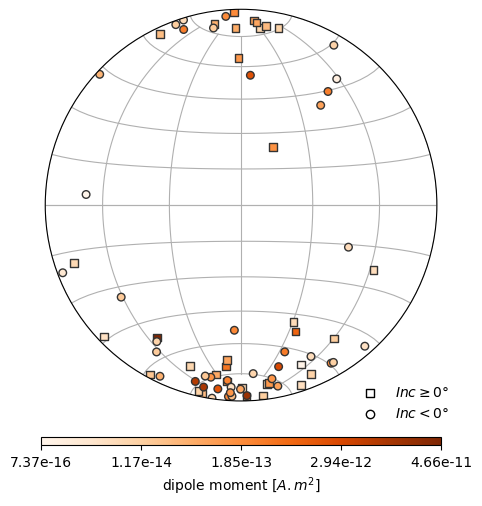

In [25]:
fig, ax = mplstereonet.subplots(1, 1, figsize=(4, 4), constrained_layout=True)
ax.grid()
estimated = mg.vector_to_angles(estimated_dipole_moments_itr_euler)
scatter_args = dict(
    vmin=np.log10(np.min(estimated[2])),
    vmax=np.log10(np.max(estimated[2])),
    cmap="Oranges",
    edgecolors="#333333",
    linewidths=1,
    s=30,
    zorder=2,
)
pos_inc = estimated[0] > 0
tmp = ax.scatter(
    *mplstereonet.line(estimated[0][pos_inc], estimated[1][pos_inc]),
    c=np.log10(estimated[2][pos_inc]),
    marker="s",
    **scatter_args,
)
tmp = ax.scatter(
    *mplstereonet.line(-estimated[0][~pos_inc], estimated[1][~pos_inc]),
    c=np.log10(estimated[2][~pos_inc]),
    marker="o",
    **scatter_args,
)

ticks=np.linspace( np.log10(np.min(estimated[2])),
                   np.log10(np.max(estimated[2])), 5)
tick_labels = []
for i in (ticks):
    tick_labels.append("{:.2e}".format(10**i))

    
clb = fig.colorbar(
    tmp, 
    cax=fig.add_axes([0, -0.1, 1, 0.02]), 
    orientation="horizontal", 
    label="dipole moment [$A.m^2$]",
    format="%.2e",
    ticks = ticks).set_ticklabels(tick_labels)

plt.scatter([],[], marker='s', color='white', edgecolors='k', label=r'$Inc \geq 0° $')
plt.scatter([],[], marker='o', color='white', edgecolors='k', label=r'$Inc < 0° $')

legend = plt.legend(bbox_to_anchor=(1.05, 9.0), frameon=1, framealpha=1.0)
frame = legend.get_frame()
frame.set_facecolor('w')
frame.set_edgecolor('w')

plt.show()

### Interfering sources method with $b_z$ vector

In [26]:
import numba
import choclo
import scipy
from micromag import TESLA_TO_NANOTESLA, MICROMETER_TO_METER

def all_dipole_moment_inversion(data, dipole_coordinates):
    
    data = data.to_xarray()
    
    n_data = len(data['bz']) #table.shape[0]
    n_params = len(dipole_coordinates[0])*3
    
    A = np.empty((n_data, n_params))
    
    d = np.array(data['bz']).ravel() / TESLA_TO_NANOTESLA #table.bz.values / TESLA_TO_NANOTESLA
    
    # Fill the Jacobian using a fast calculation with numba
    _dipole_jacobian_fast(
        data.x.values * MICROMETER_TO_METER,
        data.y.values * MICROMETER_TO_METER,
        data.z.values * MICROMETER_TO_METER,
        dipole_coordinates[0] * MICROMETER_TO_METER,
        dipole_coordinates[1] * MICROMETER_TO_METER,
        dipole_coordinates[2] * MICROMETER_TO_METER,
        A,
    )
    
    
    
    hessian = A.T @ A
    neg_gradient = A.T @ d
    dipole_moment = scipy.linalg.solve(hessian, neg_gradient, assume_a="pos")
    residuals = d - A @ dipole_moment
    
    dipole_moment = np.reshape(dipole_moment, (int(n_params/3), 3) )
    return dipole_moment 

@numba.jit(nopython=True, parallel=True)
def _dipole_jacobian_fast(e, n, u, de, dn, du, jacobian):
    """
    This is the bit that runs the fast for-loops
    """
    constant = choclo.constants.VACUUM_MAGNETIC_PERMEABILITY / (4 * np.pi)

    for j in numba.prange(len(de)):
        for i in numba.prange(len(e)):
            # Calculating the distance only once saves a lot of computation time
            distance = choclo.utils.distance_cartesian(
                e[i],
                n[i],
                u[i],
                de[j],
                dn[j],
                du[j],
            )
            # These are the second derivatives of 1/r
            jacobian[i, j*3] = constant * choclo.point.kernel_eu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance   =distance,
            )
            jacobian[i, j*3+1] = constant * choclo.point.kernel_nu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance=distance,
            )
            jacobian[i, j*3+2] = constant * choclo.point.kernel_uu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance   =distance,
            )
            


In [27]:
start_interf_bz_time = time.perf_counter()

estimated_dipole_moments_interf_bz = all_dipole_moment_inversion(df, positions_itr)
# print(estimated_dipole_moments_interf_bz)

end_interf_bz_time = time.perf_counter()

In [28]:
interf_bz_time = end_interf_bz_time-start_interf_bz_time
print(f"Time for the iterative Euler solution and interfering sources bz estimation: {round(itr_euler_time+interf_bz_time, 2)} seconds", )

Time for the iterative Euler solution and interfering sources bz estimation: 36.25 seconds


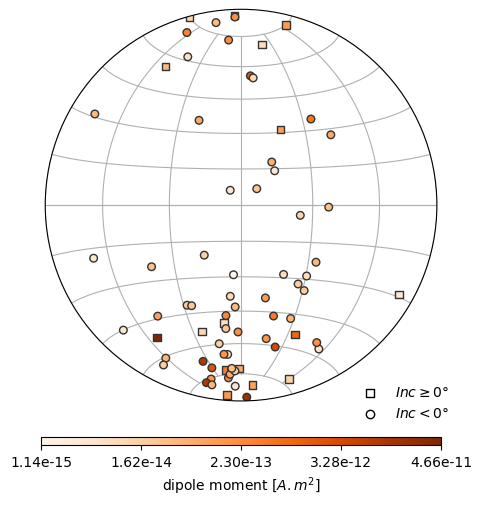

In [29]:
fig, ax = mplstereonet.subplots(1, 1, figsize=(4, 4), constrained_layout=True)
ax.grid()
estimated = mg.vector_to_angles(estimated_dipole_moments_interf_bz)
scatter_args = dict(
    vmin=np.log10(np.min(estimated[2])),
    vmax=np.log10(np.max(estimated[2])),
    cmap="Oranges",
    edgecolors="#333333",
    linewidths=1,
    s=30,
    zorder=2,
)
pos_inc = estimated[0] > 0
tmp = ax.scatter(
    *mplstereonet.line(estimated[0][pos_inc], estimated[1][pos_inc]),
    c=np.log10(estimated[2][pos_inc]),
    marker="s",
    **scatter_args,
)
tmp = ax.scatter(
    *mplstereonet.line(-estimated[0][~pos_inc], estimated[1][~pos_inc]),
    c=np.log10(estimated[2][~pos_inc]),
    marker="o",
    **scatter_args,
)

ticks=np.linspace( np.log10(np.min(estimated[2])),
                   np.log10(np.max(estimated[2])), 5)
tick_labels = []
for i in (ticks):
    tick_labels.append("{:.2e}".format(10**i))

    
clb = fig.colorbar(
    tmp, 
    cax=fig.add_axes([0, -0.1, 1, 0.02]), 
    orientation="horizontal", 
    label="dipole moment [$A.m^2$]",
    format="%.2e",
    ticks = ticks).set_ticklabels(tick_labels)

plt.scatter([],[], marker='s', color='white', edgecolors='k', label=r'$Inc \geq 0° $')
plt.scatter([],[], marker='o', color='white', edgecolors='k', label=r'$Inc < 0° $')

legend = plt.legend(bbox_to_anchor=(1.05, 9.0), frameon=1, framealpha=1.0)
frame = legend.get_frame()
frame.set_facecolor('w')
frame.set_edgecolor('w')

plt.show()

### Interfering sources method with $\frac{\partial b_z}{\partial z}$ vector

In [30]:
import numba
import choclo
import scipy
from micromag import TESLA_TO_NANOTESLA, MICROMETER_TO_METER


from numba import jit

@jit(nopython=True)
def kernel_uuu(
    easting_p, northing_p, upward_p, easting_q, northing_q, upward_q, distance
):
    r"""
    Second derivative of the inverse of the distance along upward-upward

    .. important ::

        The coordinates of the two points must be in Cartesian coordinates and
        have the same units.

    Parameters
    ----------
    easting_p : float
        Easting coordinate of point :math:`\mathbf{p}`.
    northing_p : float
        Northing coordinate of point :math:`\mathbf{p}`.
    upward_p : float
        Upward coordinate of point :math:`\mathbf{p}`.
    easting_q : float
        Easting coordinate of point :math:`\mathbf{q}`.
    northing_q : float
        Northing coordinate of point :math:`\mathbf{q}`.
    upward_q : float
        Upward coordinate of point :math:`\mathbf{q}`.
    distance : float
        Euclidean distance between points :math:`\mathbf{p}` and
        :math:`\mathbf{q}`.

    Returns
    -------
    kernel : float
        Value of the kernel function.


    """
    return 9 * (upward_p - upward_q) / distance**5 - 15 * (upward_p - upward_q)**3 / distance**7



@jit(nopython=True)
def kernel_euu(
    easting_p, northing_p, upward_p, easting_q, northing_q, upward_q, distance
):
    r"""
    Second derivative of the inverse of the distance along easting-upward

    .. important ::

        The coordinates of the two points must be in Cartesian coordinates and
        have the same units.

    Parameters
    ----------
    easting_p : float
        Easting coordinate of point :math:`\mathbf{p}`.
    northing_p : float
        Northing coordinate of point :math:`\mathbf{p}`.
    upward_p : float
        Upward coordinate of point :math:`\mathbf{p}`.
    easting_q : float
        Easting coordinate of point :math:`\mathbf{q}`.
    northing_q : float
        Northing coordinate of point :math:`\mathbf{q}`.
    upward_q : float
        Upward coordinate of point :math:`\mathbf{q}`.
    distance : float
        Euclidean distance between points :math:`\mathbf{p}` and
        :math:`\mathbf{q}`.

    Returns
    -------
    kernel : float
        Value of the kernel function.
    """
    return (  3 *  (easting_p - easting_q) / distance**5 
            - 15 * (easting_p - easting_q) * (upward_p - upward_q)**2 / distance**7)


@jit(nopython=True)
def kernel_nuu(
    easting_p, northing_p, upward_p, easting_q, northing_q, upward_q, distance
):
    r"""
    Second derivative of the inverse of the distance along easting-upward

    .. important ::

        The coordinates of the two points must be in Cartesian coordinates and
        have the same units.

    Parameters
    ----------
    easting_p : float
        Easting coordinate of point :math:`\mathbf{p}`.
    northing_p : float
        Northing coordinate of point :math:`\mathbf{p}`.
    upward_p : float
        Upward coordinate of point :math:`\mathbf{p}`.
    easting_q : float
        Easting coordinate of point :math:`\mathbf{q}`.
    northing_q : float
        Northing coordinate of point :math:`\mathbf{q}`.
    upward_q : float
        Upward coordinate of point :math:`\mathbf{q}`.
    distance : float
        Euclidean distance between points :math:`\mathbf{p}` and
        :math:`\mathbf{q}`.

    Returns
    -------
    kernel : float
        Value of the kernel function.
    """
    return (  3 *  (northing_p - northing_q) / distance**5 
            - 15 * (northing_p - northing_q) * (upward_p - upward_q)**2 / distance**7)


def z_deriv_all_dipole_moment_inversion(data, dipole_coordinates):
    
    data = data.to_xarray()
    
    n_data = len(data['z_deriv']) #table.shape[0]
    n_params = len(dipole_coordinates[0])*3
    
    A = np.empty((n_data, n_params))
    
    d = np.array(data['z_deriv']).ravel() #*-1.0e-3 # CONVERTING nT/microm to T/m
    
    # Fill the Jacobian using a fast calculation with numba
    _dipole_jacobian_fast(
        data.x.values * MICROMETER_TO_METER,
        data.y.values * MICROMETER_TO_METER,
        data.z.values * MICROMETER_TO_METER,
        dipole_coordinates[0] * MICROMETER_TO_METER,
        dipole_coordinates[1] * MICROMETER_TO_METER,
        dipole_coordinates[2] * MICROMETER_TO_METER,
        A,
    )
    
    
    
    hessian = A.T @ A
    neg_gradient = A.T @ d
    dipole_moment = scipy.linalg.solve(hessian, neg_gradient, assume_a="pos")
    residuals = d - A @ dipole_moment
    
    dipole_moment = np.reshape(dipole_moment, (int(n_params/3), 3) )
    return dipole_moment * 1.0e-3


@numba.jit(nopython=True, parallel=True)
def _dipole_jacobian_fast(e, n, u, de, dn, du, jacobian):
    """
    This is the bit that runs the fast for-loops
    """
    constant = choclo.constants.VACUUM_MAGNETIC_PERMEABILITY / (4 * np.pi)

    for j in numba.prange(len(de)):
        for i in numba.prange(len(e)):
            # Calculating the distance only once saves a lot of computation time
            distance = choclo.utils.distance_cartesian(
                e[i],
                n[i],
                u[i],
                de[j],
                dn[j],
                du[j],
            )
            # These are the second derivatives of 1/r
            jacobian[i, j*3] = constant*kernel_euu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance   =distance,
            )
            jacobian[i, j*3+1] = constant*kernel_nuu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance=distance,
            )
            jacobian[i, j*3+2] = constant*kernel_uuu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance   =distance,
            )
            

In [31]:
start_interf_z_deriv_time = time.perf_counter()

estimated_dipole_moments_interf_z_deriv = z_deriv_all_dipole_moment_inversion(df, positions_itr)
# print(estimated_dipole_moments_interf_bz)

end_interf_z_deriv_time = time.perf_counter()

In [32]:
interf_z_deriv_time = end_interf_z_deriv_time-start_interf_z_deriv_time
print(f"Time for the iterative Euler solution and interfering sources bz estimation: {round(itr_euler_time+interf_z_deriv_time, 2)} seconds", )

Time for the iterative Euler solution and interfering sources bz estimation: 36.18 seconds


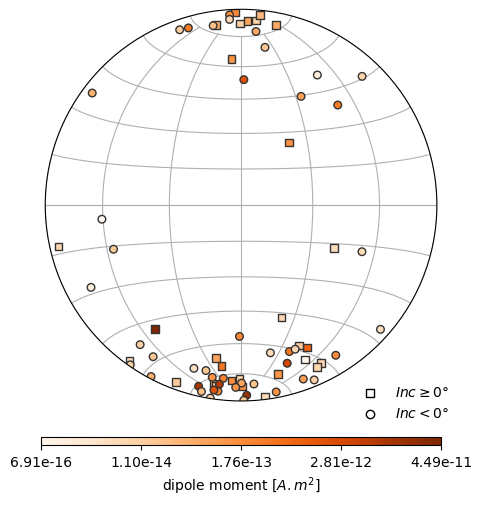

In [33]:
fig, ax = mplstereonet.subplots(1, 1, figsize=(4, 4), constrained_layout=True)
ax.grid()
estimated = mg.vector_to_angles(estimated_dipole_moments_interf_z_deriv)
scatter_args = dict(
    vmin=np.log10(np.min(estimated[2])),
    vmax=np.log10(np.max(estimated[2])),
    cmap="Oranges",
    edgecolors="#333333",
    linewidths=1,
    s=30,
    zorder=2,
)
pos_inc = estimated[0] > 0
tmp = ax.scatter(
    *mplstereonet.line(estimated[0][pos_inc], estimated[1][pos_inc]),
    c=np.log10(estimated[2][pos_inc]),
    marker="s",
    **scatter_args,
)
tmp = ax.scatter(
    *mplstereonet.line(-estimated[0][~pos_inc], estimated[1][~pos_inc]),
    c=np.log10(estimated[2][~pos_inc]),
    marker="o",
    **scatter_args,
)

ticks=np.linspace( np.log10(np.min(estimated[2])),
                   np.log10(np.max(estimated[2])), 5)
tick_labels = []
for i in (ticks):
    tick_labels.append("{:.2e}".format(10**i))

    
clb = fig.colorbar(
    tmp, 
    cax=fig.add_axes([0, -0.1, 1, 0.02]), 
    orientation="horizontal", 
    label="dipole moment [$A.m^2$]",
    format="%.2e",
    ticks = ticks).set_ticklabels(tick_labels)

plt.scatter([],[], marker='s', color='white', edgecolors='k', label=r'$Inc \geq 0° $')
plt.scatter([],[], marker='o', color='white', edgecolors='k', label=r'$Inc < 0° $')

legend = plt.legend(bbox_to_anchor=(1.05, 9.0), frameon=1, framealpha=1.0)
frame = legend.get_frame()
frame.set_facecolor('w')
frame.set_edgecolor('w')

plt.show()

# Final Comparison

In [34]:
fig_dir = pathlib.Path("..") / "paper" / "figures"
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}

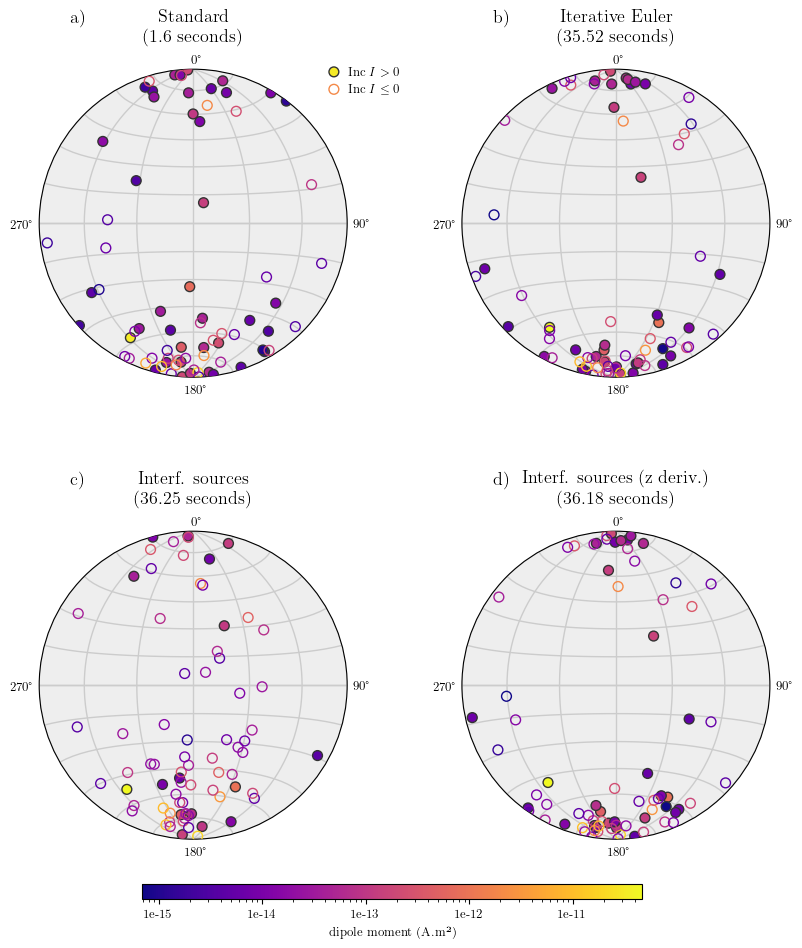

In [35]:
with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(10, 10))
    axes = []

#     estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
#     vmin = np.min(estimated)
#     vmax = np.max(estimated)
    
    estimated1 = mg.vector_to_angles(estimated_dipole_moments)[2]
    estimated2 = mg.vector_to_angles(estimated_dipole_moments_itr_euler)[2]
    estimated3 = mg.vector_to_angles(estimated_dipole_moments_interf_bz)[2]
    estimated4 = mg.vector_to_angles(estimated_dipole_moments_interf_z_deriv)[2]
    
    vmin = np.min([np.min(estimated1),np.min(estimated2),np.min(estimated3),np.min(estimated4)])
    vmax = np.max([np.max(estimated1),np.max(estimated2),np.max(estimated3),np.max(estimated4)])
    
    cmap = "plasma"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize

        
        
    ## STANDARD METHOD
    ax = fig.add_subplot(2, 2, 1, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs)
    ax.legend(loc=(0.9, 0.9), frameon=False, handletextpad=0.1, prop = {'size' : 9})
    fig.colorbar(
        tmp, 
        cax=fig.add_axes([0.25, 0.05, 0.5, 0.015]), 
        format="%.0g",
        label="dipole moment (A.m²)",
        orientation="horizontal",
    )

    
    
    
    ## ITERATIVE METHOD
    ax = fig.add_subplot(2, 2, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments_itr_euler, marker="o", zorder=1000, label="Inc", **kwargs)

    
    
    ## ITERATIVE METHOD W/ Bz DATA
    ax = fig.add_subplot(2, 2, 3, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments_interf_bz, marker="o", zorder=1000, label="Inc", **kwargs)

    
    
    
    ## ITERATIVE METHOD W/ Bz deriv DATA
    ax = fig.add_subplot(2, 2, 4, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments_interf_z_deriv, marker="o", zorder=1000, label="Inc", **kwargs)

    
           
    
    
    
    
    titles = ([r'Standard'+'\n'+ f'({round(inversion_time, 2)} seconds)', 
           'Iterative Euler'+'\n'+ f'({round(itr_euler_time, 2)} seconds)', 
           'Interf. sources'+'\n'+ f'({round(itr_euler_time+interf_bz_time, 2)} seconds)', 
           'Interf. sources (z deriv.)'+'\n'+ f'({round(itr_euler_time+interf_z_deriv_time, 2)} seconds)'])

    for ax, letter, title in zip(axes, "a b c d".split(), titles):
        ax.text(0.1, 1.15, f"{letter})   ", transform=ax.transAxes, fontsize=13)
        ax.set_title(title+'\n', fontsize=13, loc='center')
    fig.subplots_adjust(wspace=0.2, hspace=0.5)

    plt.show()

# R-squared score filter

In [36]:
def calculated_r2_interf_sources_bz(data, coordinates, dipole_coordinates, dipole_moments, 
                                 windows, height_difference):
    calculated_r2_interf = []
    
    # Calculate predicted model
    predicted_model = mg.dipole_bz(coordinates, dipole_coordinates, dipole_moments)
    
    # Calculate predicted model 
    predicted = vd.make_xarray_grid(coordinates, predicted_model, data_names=["bz"], 
                                    dims=("y", "x"), extra_coords_names="z")
    predicted.x.attrs = {"units": "µm"}
    predicted.y.attrs = {"units": "µm"}
    predicted.bz.attrs = {"long_name": "vertical magnetic field", "units": "nT"}

    # Upward continuation of the predicted model 
    pred_up = (
                hm.upward_continuation(predicted.bz, height_difference)
                .assign_attrs(data_copy.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data.x, y=data.y)
                .assign_coords(z=data.z + height_difference)
               )
    # Upward continuation of data
    
    data_up = (
                hm.upward_continuation(data.bz, height_difference)
                .assign_attrs(data.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data.x, y=data.y)
                .assign_coords(z=data.z + height_difference)
               )
    
    # Calculate r2 of each window
    for window in windows:
        data_up_slice = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
        pred_up_slice = pred_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
        
        residuals = data_up_slice.bz.values - pred_up_slice.bz.values
        residuals_sum_sq = np.sum(residuals**2)
        
        # R² Coeficient of Determination (dimensionless)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_up_slice.bz.values - np.mean(data_up_slice.bz.values)) ** 2
        
        calculated_r2_interf.append(r2)
    
    return np.array(calculated_r2_interf)



def calculated_r2_interf_sources_bzz(data, coordinates, dipole_coordinates, dipole_moments, 
                                 windows, height_difference):
    calculated_r2_interf = []
    
    # Calculate predicted model
    predicted_model = mg.dipole_bz(coordinates, dipole_coordinates, dipole_moments)
    
    # Calculate predicted model 
    predicted = vd.make_xarray_grid(coordinates, predicted_model, data_names=["bz"], 
                                    dims=("y", "x"), extra_coords_names="z")
    predicted.x.attrs = {"units": "µm"}
    predicted.y.attrs = {"units": "µm"}
    predicted.bz.attrs = {"long_name": "vertical magnetic field", "units": "nT"}
    
    # Upward continuation of the predicted model 
    pred_up = (
                hm.upward_continuation(predicted.bz, height_difference)
                .assign_attrs(data_copy.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data.x, y=data.y)
                .assign_coords(z=data.z + height_difference)
               )
    # Upward continuation of data
    
#     # remove median
#     median = np.median(data.bz.values)
#     data.bz.values -= median
    
    data_up = (
                hm.upward_continuation(data.bz, height_difference)
                .assign_attrs(data.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data.x, y=data.y)
                .assign_coords(z=data.z + height_difference)
               )
    
    data_up = data_up.assign(mg.data_gradients(data_up.bz))
    pred_up = data_up.assign(mg.data_gradients(pred_up.bz))
    
    # Calculate r2 of each window
    for window in windows:
        data_up_slice = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
        pred_up_slice = pred_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
        
        residuals = data_up_slice.z_deriv.values - pred_up_slice.z_deriv.values
        residuals_sum_sq = np.sum(residuals**2)
        
        # R² Coeficient of Determination (dimensionless)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_up_slice.z_deriv.values - np.mean(data_up_slice.z_deriv.values)) ** 2
        
        calculated_r2_interf.append(r2)
    
    return np.array(calculated_r2_interf)

In [37]:
import warnings
warnings.filterwarnings('ignore')

calculated_r2_interf_bz = calculated_r2_interf_sources_bz(data, coordinates, positions_itr, 
                                                    estimated_dipole_moments_interf_bz, 
                                                    np.array(windows_filtered), height_difference)

calculated_r2_interf_z_deriv = calculated_r2_interf_sources_bzz(data, coordinates, positions_itr, 
                                                    estimated_dipole_moments_interf_z_deriv, 
                                                    np.array(windows_filtered), height_difference)


In [38]:
print(np.array(calculated_r2)[np.array(calculated_r2)>=0.85])
print()
print(calculated_r2_itr_euler[calculated_r2_itr_euler>=0.85])
print()
print(calculated_r2_interf_bz[calculated_r2_interf_bz>=0.85])
print()
print(calculated_r2_interf_z_deriv[calculated_r2_interf_z_deriv>=0.85])
print(len(np.array(calculated_r2)[np.array(calculated_r2)>=0.85]), len(calculated_r2_itr_euler[calculated_r2_itr_euler>=0.85]))

[0.88785769 0.91735136 0.9946005  0.972851   0.9972637  0.98168351
 0.98489374 0.99917826 0.99607567 0.96030063 0.9991423  0.99705428
 0.95152628 0.93842917 0.99490758 0.97903222 0.96794878 0.96675444
 0.94388367 0.98335229 0.96391143 0.97033934 0.96127153 0.95532205
 0.99606017 0.93531699 0.9170259  0.90111836 0.95671122 0.92863515
 0.99063131 0.97041723 0.99235214 0.8627354  0.94280392 0.87299364
 0.86993956 0.8940612  0.85441422 0.94166055 0.96703895 0.9193462
 0.98072462 0.90783064 0.90438294 0.92110664]

[0.94255639 0.94278169 0.99594514 0.98544468 0.99786313 0.98886555
 0.99862645 0.99923567 0.8939896  0.99688124 0.98387998 0.99938024
 0.99770903 0.995252   0.98701894 0.99784733 0.98578636 0.98898991
 0.9684055  0.96151814 0.98502397 0.97451239 0.99125748 0.99400578
 0.91463426 0.9768826  0.99827455 0.98074398 0.85012139 0.94930822
 0.98683512 0.97457258 0.98708036 0.99620317 0.96983982 0.99659243
 0.95817323 0.85646826 0.87860768 0.89056811 0.92282556 0.89864183
 0.95988932 0.93

# Paper's figures 

In [39]:
fig_dir = pathlib.Path("..") / "paper" / "figures"
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}

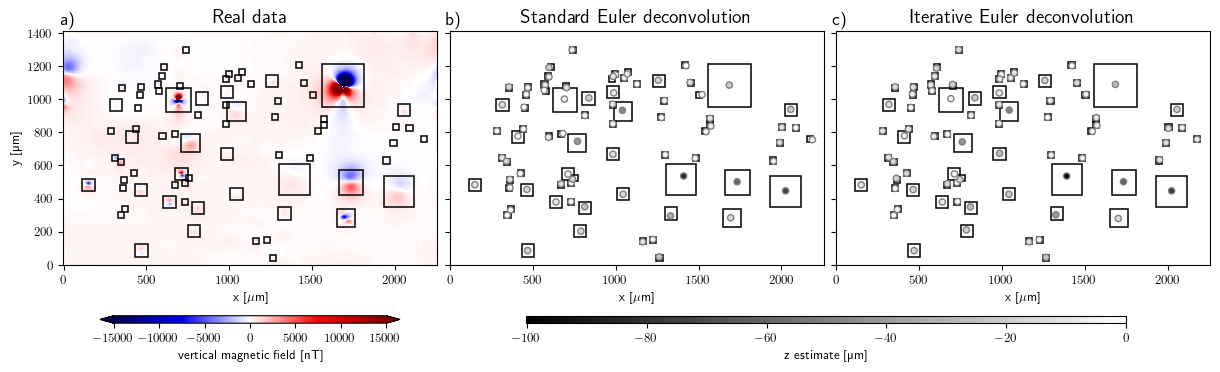

In [40]:
with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True, sharex=True)
    cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.0, shrink=0.5)

    # data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
    axes = axes.ravel()

    ax = axes[0]


    tmp1 = data_up['bz'].plot.pcolormesh(ax=ax, cmap='seismic', vmin=-15000, vmax=15000, add_colorbar=False)#, cbar_kwargs=cbar_kwargs)
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)


    scale = vd.maxabs((positions[2], positions_itr[2]))

    ax = axes[1]
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)

    tmp = ax.scatter(*positions[:2], c=positions[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    ax = axes[2]
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)

    tmp = ax.scatter(*positions_itr[:2], c=positions_itr[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    titles = ([r'Real data',
               r'Standard Euler deconvolution', 
               r'Iterative Euler deconvolution'])
    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(-0.01, 1.025, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")
        ax.set_title(title, fontsize=14)
        ax.set_xlabel(r"x [$\mu$m]")

    plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


    fig.colorbar(tmp1, **cbar_kwargs, extend='both', label="vertical magnetic field [nT]", cax=fig.add_axes([0.075, 0.15, 0.25, 0.015]))
    fig.colorbar(tmp, **cbar_kwargs, label="z estimate [µm]", cax=fig.add_axes([0.43, 0.15, 0.5, 0.015]))
    fig.savefig(fig_dir / "euler-comparion-real.png", dpi=300, facecolor='w', bbox_inches='tight')
    
plt.show()


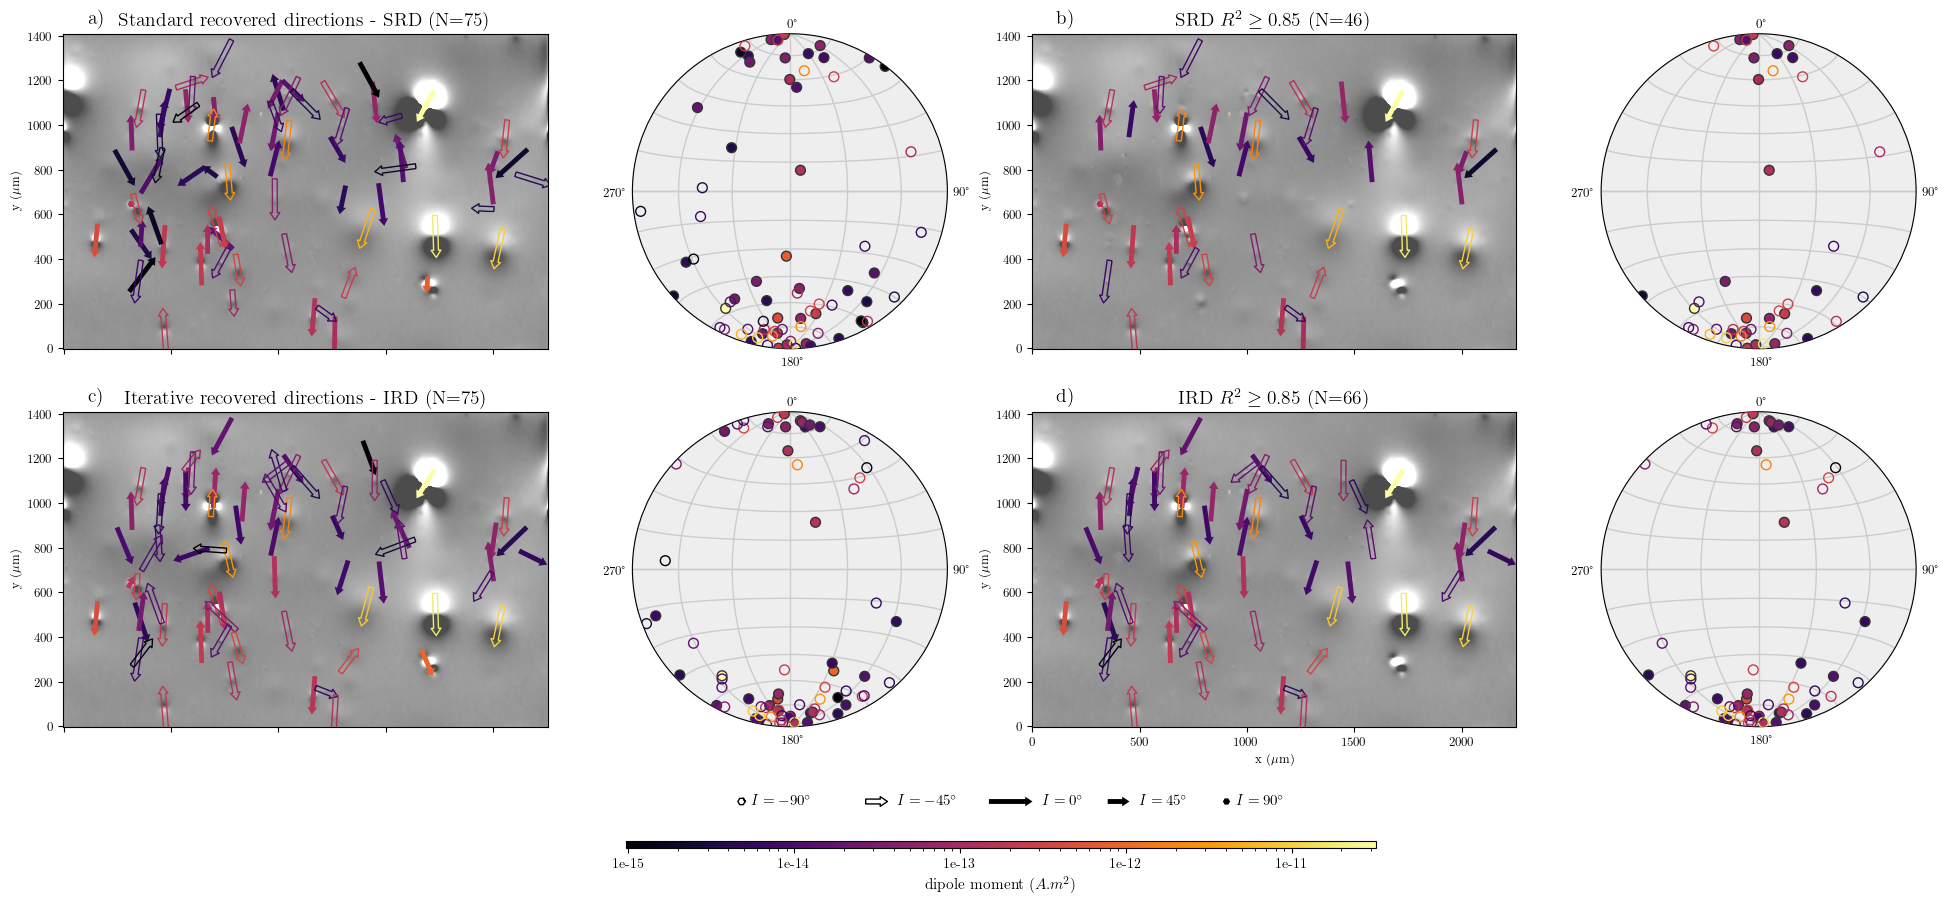

In [41]:
with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(25, 9))
    
    axes = []

    estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
    vmin = np.min(estimated)
    vmax = np.max(estimated)
    cmap = "inferno"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize
    
#################################################################################################
#                                             Maps
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 1)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 1500
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions, estimated_dipole_moments, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)

    pos_filter= ( (np.array(calculated_r2) > 0.85) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions)[0][pos_filter], 
                                  np.array(positions)[1][pos_filter], 
                                  np.array(positions)[2][pos_filter]
                                 ])
    #2
    ax = fig.add_subplot(2, 4, 3)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 1500
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)
    
#     clb = fig.colorbar(
#         tmp, 
#         cax=fig.add_axes([0.25, 0.05, 0.5, 0.0075]), 
#         format="%.0g",
# #         label="dipole moment (A.m²)",
#         orientation="horizontal"
#     )
    
#     clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
#     clb.ax.tick_params(labelsize=10)


    #3
    ax = fig.add_subplot(2, 4, 5)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 1500
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions, estimated_dipole_moments_itr_euler, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)


    pos_filter= ( (np.array(calculated_r2_itr_euler) > 0.85))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments_itr_euler)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions)[0][pos_filter], 
                                  np.array(positions)[1][pos_filter], 
                                  np.array(positions)[2][pos_filter]
                                 ])
    #4
    ax = fig.add_subplot(2, 4, 7)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 1500
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )

    ax.set_ylabel("y ($\mu$m)")
    ax.set_xlabel("x ($\mu$m)")

    
    clb = fig.colorbar(
        tmp, 
        # cax=fig.add_axes([0.12, -0.025, 0.73, 0.0075]), 
        cax=fig.add_axes([0.35, -0.025, 0.3, 0.0075]), 
        format="%.0g",
#         label="dipole moment (A.m²)",
        orientation="horizontal"
    )
    
    clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
    clb.ax.tick_params(labelsize=10)
#################################################################################################
#                                           Stereograms
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N1 = np.asarray(estimated_dipole_moments).shape[0]
    
    pos_filter= ( (np.array(calculated_r2) > 0.85) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter]
                                     ]).T

    N2 = filter_estimated_d_m.shape[0]
    #2
    ax = fig.add_subplot(2, 4, 4, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m, marker="o", zorder=1000, **kwargs, add_ticks=True)


    #3
    ax = fig.add_subplot(2, 4, 6, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments_itr_euler, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N3 = np.asarray(estimated_dipole_moments_itr_euler).shape[0]
    
    pos_filter= ( (np.array(calculated_r2_itr_euler) > 0.85))

    filter_estimated_d_m_itr = np.array( [np.array(estimated_dipole_moments_itr_euler)[:,0][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler)[:,1][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler)[:,2][pos_filter]
                                         ]).T
    
    N4 = filter_estimated_d_m_itr.shape[0]
    #4
    ax = fig.add_subplot(2, 4, 8, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m_itr, marker="o", zorder=1000, **kwargs, add_ticks=True)
    # ax.legend(loc=(-0.35, -0.05), frameon=False, handletextpad=0.1, prop = {'size' : 12})


    # Inc values seem to be reversed because the function uses 90 - inc to plot instead of inc.
    ax.quiverkey(negquiver,-0.6, -0.235, 0., label="$I = -90^\circ$", labelpos="E", edgecolor='k', 
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(negquiver, -0.3, -0.235, 45, label="$I = -45^\circ$", labelpos="E", edgecolor='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.0, -0.235, 90, label="$I =   0^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.2, -0.235, 45, label="$I =  45^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.4, -0.235, 0., label="$I =  90^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    
    titles = (f'Standard recovered directions - SRD (N={N1})', f'SRD $R^2 \geq 0.85$ (N={N2})',
              f'Iterative recovered directions - IRD (N={N3})', f'IRD $R^2 \geq 0.85$ (N={N4})')

    for ax, letter, title in zip(axes, "a b c d".split(), titles):
        ax.text(0.05, 1.031, f"{letter})", transform=ax.transAxes, fontsize=14)
        ax.set_title(title, fontsize=14)
        ax.set_aspect("auto")
    
        
    fig.subplots_adjust(wspace=0.0, hspace=0.2)
    fig.savefig(fig_dir / "real-data-stereograms.png", dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()